In [5]:
%load_ext autoreload
%autoreload 2
import os
import sys


import numpy as np
from graphviz import Digraph

module_path = os.path.abspath(os.path.join('../')) # or the path
sys.path.append(module_path)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

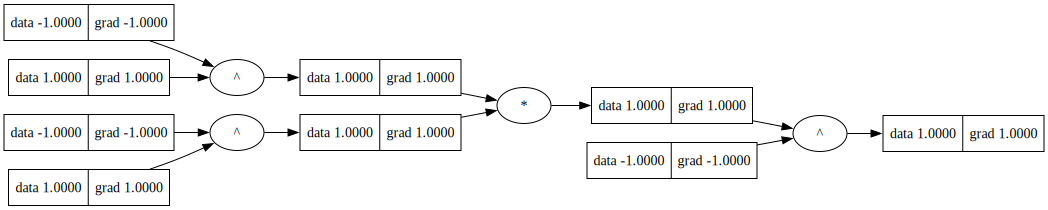

In [8]:
# define a simple neural network

# check composition
from engine import Bool

y = Bool(-1);
x1 = Bool(1); x2 = Bool(1)
w1 = Bool(-1); w2 = Bool(-1); 

h1 = x1^w1
h2 = x2^w2

z = h1*h2
L = z^y

L.backward()

draw_dot(L)

In [14]:
from engine import Value
from nn import Neuron, Layer, MLP

# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [50]:
from engine import Value
from engine import Bool
from bnn import ProdTron, SumTron, ProdLayer

# initialize a model 
n1 = ProdTron(2)
n2 = SumTron(2)
print(n2)
print(n1)

x = [Bool(1),Bool(1)]
y = n1(x)
print(n1.parameters())
print(y)

m = ProdLayer(2,3)
print(m)


SumTron(2)
ProdTron(2)
[Bool(data=-1, grad=0), Bool(data=-1, grad=0)]
Bool(data=1, grad=0)
Prod Layer of [ProdTron(2), ProdTron(2), ProdTron(2)]


In [56]:
from bnn import ProdLayer, SumLayer
m = ProdLayer(2,3)
x = [Bool(1),Bool(1)]
print(m)
print(m(x))
print(m.parameters())

z = SumLayer(2,2)
print(z)
print(z.parameters())



Prod Layer of [ProdTron(2), ProdTron(2), ProdTron(2)]
[Bool(data=-1, grad=0), Bool(data=-1, grad=0), Bool(data=1, grad=0)]
[Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=-1, grad=0), Bool(data=-1, grad=0)]
Prod Layer of [SumTron(2), SumTron(2)]
[Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0)]


In [109]:
# change the params and see it is changing
m = ProdLayer(2,3)
print(m.parameters())


[Bool(data=-1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0), Bool(data=1, grad=0)]


In [108]:
from engine import Bool
from bnn import MLP
m = MLP(2,[1],[1])
x = [Bool(1),Bool(1)]
yh = m(x)
y = Bool(-1)

print('yh',yh)
print('y',y)
m.zero_grad()
loss = y^yh
loss.backward()
for p in m.parameters():
    print(p)

yh Bool(data=-1, grad=0)
y Bool(data=-1, grad=0)
Bool(data=-1, grad=1)
Bool(data=-1, grad=1)
Bool(data=1, grad=-1)


In [ ]:
# loss function
def loss(data, model, batch_size=None, mode='train'):
    
    Xb = data['X']
    yb = data['y']
    
    inputs = [list(map(Bool, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    if mode == 'train':
        losses = [ yi^scorei for yi, scorei in zip(yb, scores)]
    else:
        losses = [ np.sign(yi.data*scorei.data) for yi, scorei in zip(yb, scores)]
    
    # also get accuracy
    accuracy = 
    return loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)